# Text Embedding Analysis: Viral Status and Retweet Count

This notebook analyzes the relationship between text embeddings and two target variables:
- `if_viral`: Binary indicator of viral status
- `retweet_count`: Number of retweets

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

/home/jqcao/anaconda3/envs/retweet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Explore Dataset

In [3]:
# Load the dataset
dataset = load_from_disk("/home/jqcao/projects/retweet-prediction/data/embedding_dataset")["train"].select(range(20000))
print(f"Dataset size: {len(dataset)}")
print(f"\nDataset features: {dataset.features}")

Dataset size: 20000

Dataset features: {'id': Value(dtype='int64', id=None), 'timestamp': Value(dtype='int64', id=None), 'retweet_count': Value(dtype='int64', id=None), 'user_verified': Value(dtype='bool', id=None), 'user_statuses_count': Value(dtype='int64', id=None), 'user_followers_count': Value(dtype='int64', id=None), 'user_friends_count': Value(dtype='int64', id=None), 'user_mentions': Value(dtype='string', id=None), 'urls': Value(dtype='string', id=None), 'hashtags': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'if_viral': Value(dtype='bool', id=None), 'embeddings': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}


In [10]:
# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame({
    'embeddings': dataset['embeddings'],
    'if_viral': np.array(dataset['retweet_count']) >= 10,
    'retweet_count': dataset['retweet_count']
})

print(f"DataFrame shape: {df.shape}")
print(f"\nEmbedding dimension: {len(df['embeddings'].iloc[0])}")

DataFrame shape: (20000, 3)

Embedding dimension: 1024


In [11]:
# Basic statistics
print("Target Variable Statistics:")
print(f"\nViral posts: {df['if_viral'].sum()} ({df['if_viral'].mean()*100:.2f}%)")
print(f"Non-viral posts: {(~df['if_viral']).sum()} ({(~df['if_viral']).mean()*100:.2f}%)")
print(f"\nRetweet count statistics:")
print(df['retweet_count'].describe())

Target Variable Statistics:

Viral posts: 3040 (15.20%)
Non-viral posts: 16960 (84.80%)

Retweet count statistics:
count     20000.000000
mean        128.536200
std        2507.996599
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      256197.000000
Name: retweet_count, dtype: float64


## 2. Data Preprocessing

In [12]:
# Extract embeddings as numpy array
X = np.array(df['embeddings'].tolist())
y_viral = df['if_viral'].values
y_retweet = df['retweet_count'].values

print(f"Embeddings shape: {X.shape}")
print(f"Viral labels shape: {y_viral.shape}")
print(f"Retweet counts shape: {y_retweet.shape}")

Embeddings shape: (20000, 1024)
Viral labels shape: (20000,)
Retweet counts shape: (20000,)


In [13]:
# Split data for both tasks
X_train, X_test, y_viral_train, y_viral_test, y_retweet_train, y_retweet_test = train_test_split(
    X, y_viral, y_retweet, test_size=0.2, random_state=42, stratify=y_viral
)

# Scale embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 16000
Test set size: 4000


## 3. Exploratory Data Analysis

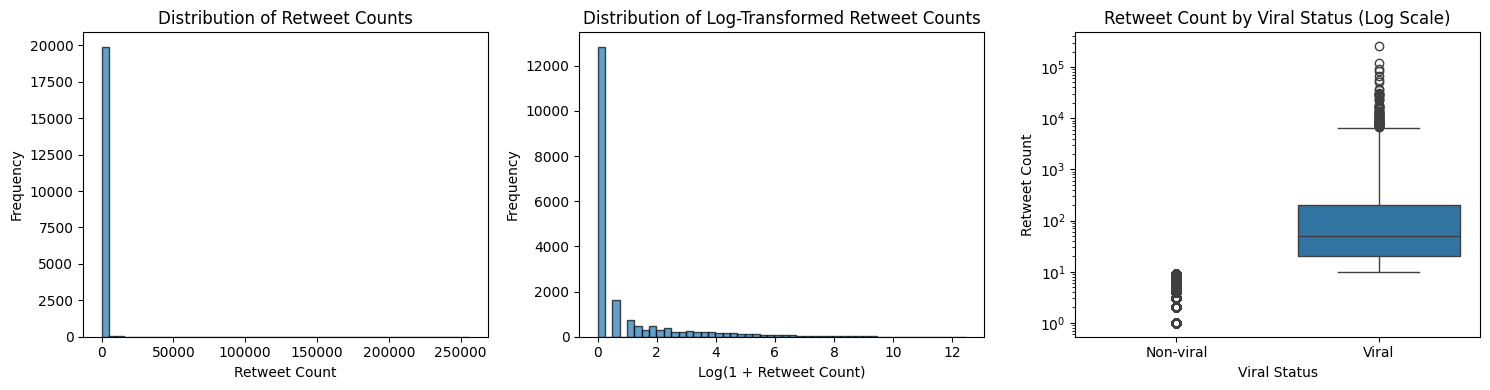

In [14]:
# Visualize retweet count distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall distribution
axes[0].hist(y_retweet, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Retweet Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Retweet Counts')

# Log-transformed distribution
axes[1].hist(np.log1p(y_retweet), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(1 + Retweet Count)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Retweet Counts')

# Box plot by viral status
data_for_box = pd.DataFrame({
    'Viral Status': ['Non-viral' if v == 0 else 'Viral' for v in y_viral],
    'Retweet Count': y_retweet
})
axes[2].set_yscale('log')
sns.boxplot(x='Viral Status', y='Retweet Count', data=data_for_box, ax=axes[2])
axes[2].set_title('Retweet Count by Viral Status (Log Scale)')

plt.tight_layout()
plt.show()

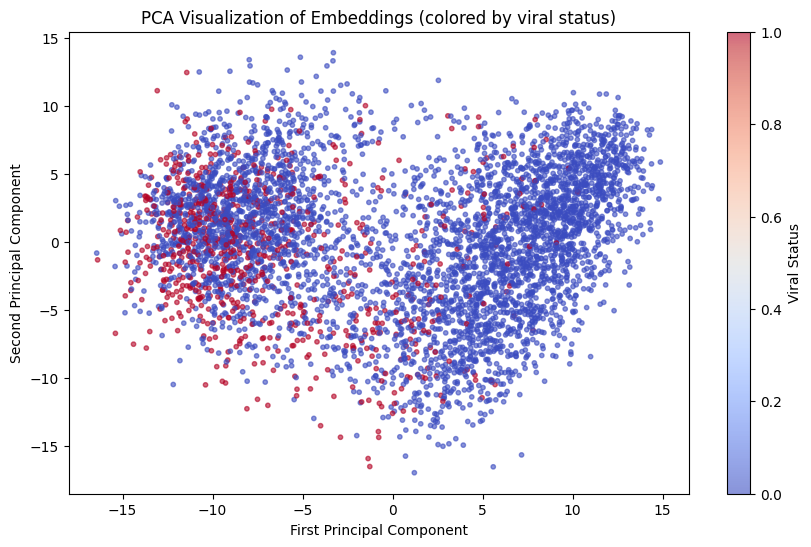

Explained variance ratio: [0.06319987 0.02551335]
Total variance explained: 0.0887


In [15]:
# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_scaled[:5000])  # Use subset for visualization

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_viral_train[:5000], 
                     cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Viral Status')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of Embeddings (colored by viral status)')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

## 4. Statistical Analysis

In [16]:
# Analyze embedding statistics by viral status
viral_embeddings = X[y_viral == 1]
non_viral_embeddings = X[y_viral == 0]

# Mean embeddings
mean_viral = np.mean(viral_embeddings, axis=0)
mean_non_viral = np.mean(non_viral_embeddings, axis=0)

# T-test for each embedding dimension
t_stats = []
p_values = []
for i in range(X.shape[1]):
    t_stat, p_val = stats.ttest_ind(viral_embeddings[:, i], non_viral_embeddings[:, i])
    t_stats.append(t_stat)
    p_values.append(p_val)

# Find most discriminative dimensions
p_values_array = np.array(p_values)
significant_dims = np.where(p_values_array < 0.05)[0]
print(f"Number of significant dimensions (p < 0.05): {len(significant_dims)}")
print(f"Proportion of significant dimensions: {len(significant_dims)/X.shape[1]:.4f}")

Number of significant dimensions (p < 0.05): 910
Proportion of significant dimensions: 0.8887


In [17]:
# Correlation analysis between embeddings and retweet count
correlations = []
for i in range(X.shape[1]):
    corr, _ = stats.pearsonr(X[:, i], y_retweet)
    correlations.append(corr)

correlations = np.array(correlations)
print(f"Max correlation: {np.max(np.abs(correlations)):.4f}")
print(f"Mean absolute correlation: {np.mean(np.abs(correlations)):.4f}")
print(f"Number of dimensions with |correlation| > 0.1: {np.sum(np.abs(correlations) > 0.1)}")

Max correlation: 0.0316
Mean absolute correlation: 0.0082
Number of dimensions with |correlation| > 0.1: 0


## 5. Predictive Modeling - Viral Classification

In [18]:
# Train multiple classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results_viral = {}
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Train model
    clf.fit(X_train_scaled, y_viral_train)
    
    # Predictions
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate
    accuracy = clf.score(X_test_scaled, y_viral_test)
    auc_score = roc_auc_score(y_viral_test, y_pred_proba)
    
    results_viral[name] = {
        'model': clf,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_viral_test, y_pred))


Training Logistic Regression...
Accuracy: 0.8532
AUC-ROC: 0.8597

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.93      0.92      3392
        True       0.52      0.41      0.46       608

    accuracy                           0.85      4000
   macro avg       0.71      0.67      0.69      4000
weighted avg       0.84      0.85      0.85      4000


Training Random Forest...
Accuracy: 0.8492
AUC-ROC: 0.8276

Classification Report:
              precision    recall  f1-score   support

       False       0.85      1.00      0.92      3392
        True       1.00      0.01      0.02       608

    accuracy                           0.85      4000
   macro avg       0.92      0.50      0.47      4000
weighted avg       0.87      0.85      0.78      4000



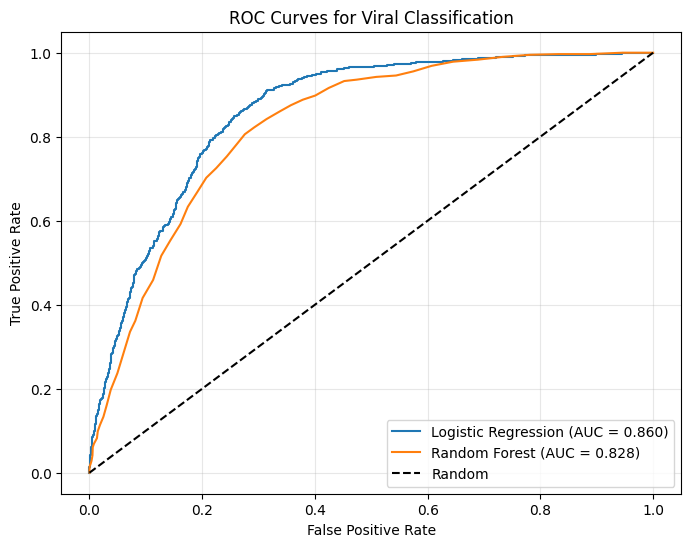

In [19]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, result in results_viral.items():
    fpr, tpr, _ = roc_curve(y_viral_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Viral Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

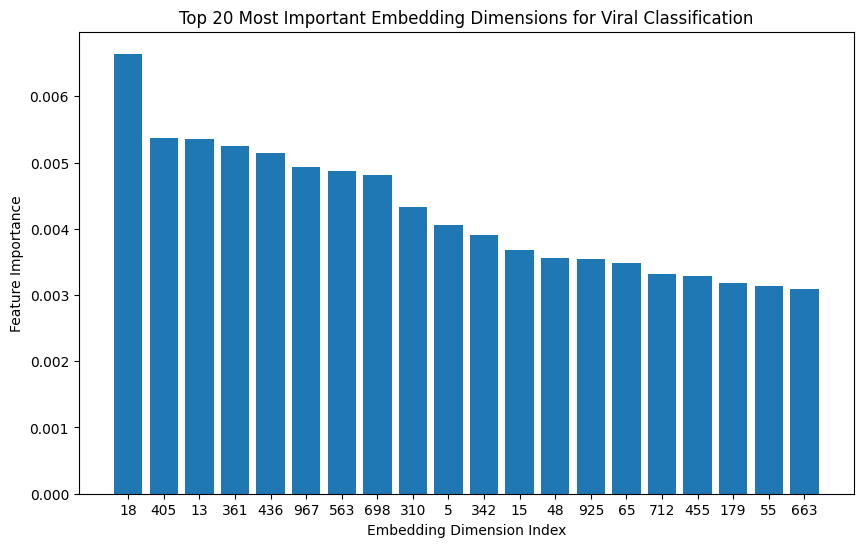

In [20]:
# Feature importance for Random Forest
rf_model = results_viral['Random Forest']['model']
feature_importance = rf_model.feature_importances_
top_k = 20
top_features = np.argsort(feature_importance)[-top_k:][::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(top_k), feature_importance[top_features])
plt.xlabel('Embedding Dimension Index')
plt.ylabel('Feature Importance')
plt.title(f'Top {top_k} Most Important Embedding Dimensions for Viral Classification')
plt.xticks(range(top_k), top_features)
plt.show()

## 6. Predictive Modeling - Retweet Count Regression

In [21]:
# Log transform retweet counts for better modeling
y_retweet_log_train = np.log1p(y_retweet_train)
y_retweet_log_test = np.log1p(y_retweet_test)

# Train regression models
regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results_regression = {}
for name, reg in regressors.items():
    print(f"\nTraining {name}...")
    
    # Train on log-transformed targets
    reg.fit(X_train_scaled, y_retweet_log_train)
    
    # Predictions
    y_pred_log = reg.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)  # Transform back to original scale
    
    # Evaluate
    mse = mean_squared_error(y_retweet_test, y_pred)
    mae = mean_absolute_error(y_retweet_test, y_pred)
    r2 = r2_score(y_retweet_test, y_pred)
    
    # Log-scale metrics
    mse_log = mean_squared_error(y_retweet_log_test, y_pred_log)
    r2_log = r2_score(y_retweet_log_test, y_pred_log)
    
    results_regression[name] = {
        'model': reg,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'mse_log': mse_log,
        'r2_log': r2_log,
        'predictions': y_pred
    }
    
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"R² Score (log-scale): {r2_log:.4f}")


Training Linear Regression...
MSE: 1004759.60
MAE: 99.16
R² Score: -0.0066
R² Score (log-scale): 0.3397

Training Ridge Regression...
MSE: 1004761.94
MAE: 99.16
R² Score: -0.0066
R² Score (log-scale): 0.3398

Training Random Forest...
MSE: 1006992.89
MAE: 99.03
R² Score: -0.0088
R² Score (log-scale): 0.2722


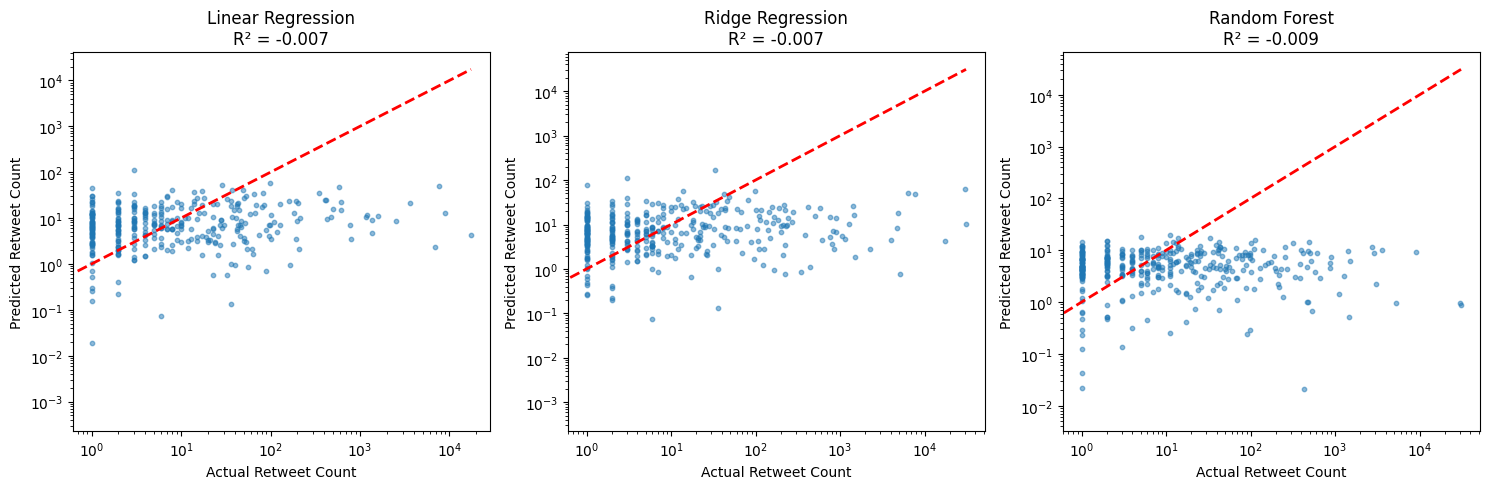

In [22]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, result) in enumerate(results_regression.items()):
    ax = axes[idx]
    
    # Sample points for visualization
    sample_idx = np.random.choice(len(y_retweet_test), min(1000, len(y_retweet_test)), replace=False)
    
    ax.scatter(y_retweet_test[sample_idx], result['predictions'][sample_idx], 
               alpha=0.5, s=10)
    
    # Add diagonal line
    max_val = max(y_retweet_test[sample_idx].max(), result['predictions'][sample_idx].max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2)
    
    ax.set_xlabel('Actual Retweet Count')
    ax.set_ylabel('Predicted Retweet Count')
    ax.set_title(f'{name}\nR² = {result["r2"]:.3f}')
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 7. Cross-Validation Analysis

In [23]:
# Cross-validation for viral classification
print("Cross-Validation Results for Viral Classification:")
print("="*50)

for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_viral_train, cv=5, scoring='roc_auc')
    print(f"\n{name}:")
    print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"CV Scores: {cv_scores}")

Cross-Validation Results for Viral Classification:

Logistic Regression:
Mean AUC: 0.8613 (+/- 0.0125)
CV Scores: [0.86639237 0.85377224 0.86976309 0.86175241 0.85481191]

Random Forest:
Mean AUC: 0.8350 (+/- 0.0147)
CV Scores: [0.83968434 0.83147777 0.83757669 0.84357656 0.82254768]


In [24]:
# Cross-validation for retweet regression
print("\nCross-Validation Results for Retweet Count Regression:")
print("="*50)

for name, reg in regressors.items():
    cv_scores = cross_val_score(reg, X_train_scaled, y_retweet_log_train, cv=5, scoring='r2')
    print(f"\n{name}:")
    print(f"Mean R² (log-scale): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"CV Scores: {cv_scores}")


Cross-Validation Results for Retweet Count Regression:

Linear Regression:
Mean R² (log-scale): 0.3506 (+/- 0.0355)
CV Scores: [0.36920849 0.34224084 0.3506979  0.36890744 0.32186874]

Ridge Regression:
Mean R² (log-scale): 0.3507 (+/- 0.0355)
CV Scores: [0.369331   0.34229652 0.35078141 0.36898866 0.32195716]


KeyboardInterrupt: 

## 8. Embedding Analysis by Performance

In [25]:
# Analyze embeddings of correctly vs incorrectly classified samples
best_clf = results_viral['Random Forest']['model']
predictions = results_viral['Random Forest']['predictions']

correct_mask = predictions == y_viral_test
incorrect_mask = ~correct_mask

# Calculate average embedding norms
embedding_norms_test = np.linalg.norm(X_test_scaled, axis=1)
print(f"Average embedding norm (correct predictions): {embedding_norms_test[correct_mask].mean():.4f}")
print(f"Average embedding norm (incorrect predictions): {embedding_norms_test[incorrect_mask].mean():.4f}")

# T-test
t_stat, p_val = stats.ttest_ind(embedding_norms_test[correct_mask], 
                                embedding_norms_test[incorrect_mask])
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

Average embedding norm (correct predictions): 31.6758
Average embedding norm (incorrect predictions): 33.2631

T-statistic: -14.6836
P-value: 0.0000


Computing t-SNE for visualization...


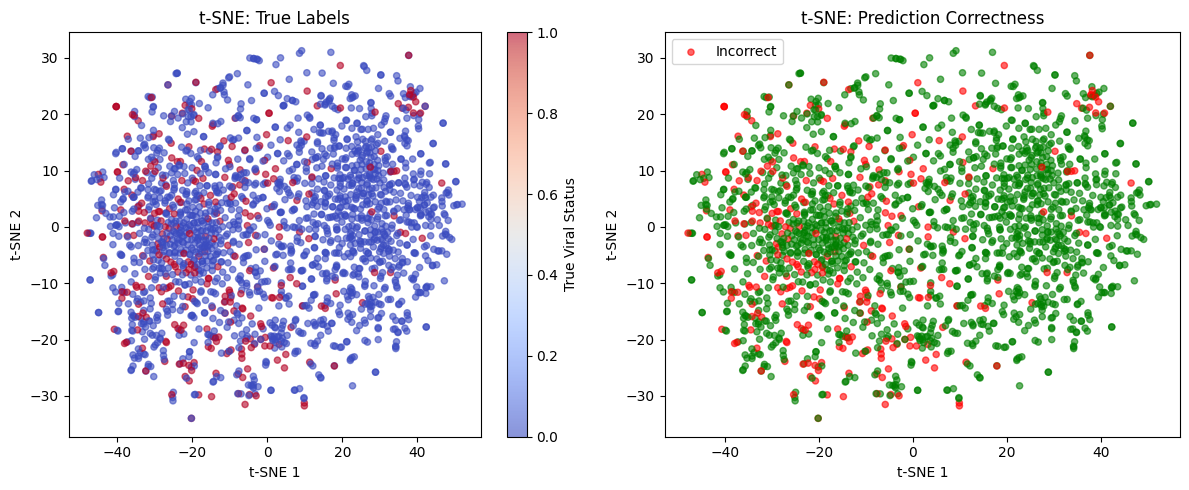

In [26]:
# t-SNE visualization of misclassified samples
print("Computing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_test_scaled[:2000])  # Use subset for speed

plt.figure(figsize=(12, 5))

# True labels
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_viral_test[:2000], 
                      cmap='coolwarm', alpha=0.6, s=20)
plt.colorbar(scatter1, label='True Viral Status')
plt.title('t-SNE: True Labels')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Prediction correctness
plt.subplot(1, 2, 2)
correctness = correct_mask[:2000]
colors = ['red' if not c else 'green' for c in correctness]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, s=20)
plt.title('t-SNE: Prediction Correctness')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(['Incorrect', 'Correct'], loc='best')

plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

In [27]:
# Summary statistics
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total samples: {len(df)}")
print(f"   - Embedding dimension: {X.shape[1]}")
print(f"   - Viral rate: {y_viral.mean()*100:.2f}%")
print(f"   - Median retweet count: {np.median(y_retweet):.0f}")
print(f"   - Mean retweet count: {np.mean(y_retweet):.2f}")

print("\n2. VIRAL CLASSIFICATION PERFORMANCE:")
for name, result in results_viral.items():
    print(f"   - {name}: Accuracy={result['accuracy']:.4f}, AUC={result['auc']:.4f}")

print("\n3. RETWEET COUNT REGRESSION PERFORMANCE:")
for name, result in results_regression.items():
    print(f"   - {name}: R²={result['r2']:.4f}, MAE={result['mae']:.2f}")

print("\n4. KEY FINDINGS:")
print(f"   - {len(significant_dims)} out of {X.shape[1]} embedding dimensions show significant")
print(f"     differences between viral and non-viral posts (p < 0.05)")
print(f"   - Maximum correlation between any embedding dimension and retweet count: {np.max(np.abs(correlations)):.4f}")
print(f"   - Embeddings can predict viral status with ~{results_viral['Random Forest']['auc']:.1%} AUC")
print(f"   - Log-scale retweet count can be predicted with R² of ~{results_regression['Random Forest']['r2_log']:.3f}")

ANALYSIS SUMMARY

1. DATASET CHARACTERISTICS:
   - Total samples: 20000
   - Embedding dimension: 1024
   - Viral rate: 15.20%
   - Median retweet count: 0
   - Mean retweet count: 128.54

2. VIRAL CLASSIFICATION PERFORMANCE:
   - Logistic Regression: Accuracy=0.8532, AUC=0.8597
   - Random Forest: Accuracy=0.8492, AUC=0.8276

3. RETWEET COUNT REGRESSION PERFORMANCE:
   - Linear Regression: R²=-0.0066, MAE=99.16
   - Ridge Regression: R²=-0.0066, MAE=99.16
   - Random Forest: R²=-0.0088, MAE=99.03

4. KEY FINDINGS:
   - 910 out of 1024 embedding dimensions show significant
     differences between viral and non-viral posts (p < 0.05)
   - Maximum correlation between any embedding dimension and retweet count: 0.0316
   - Embeddings can predict viral status with ~82.8% AUC
   - Log-scale retweet count can be predicted with R² of ~0.272


In [ ]:
# Save best models
import joblib

# Save the best models
joblib.dump(results_viral['Random Forest']['model'], 'best_viral_classifier.pkl')
joblib.dump(results_regression['Random Forest']['model'], 'best_retweet_regressor.pkl')
joblib.dump(scaler, 'embedding_scaler.pkl')

print("Best models saved:")
print("- best_viral_classifier.pkl")
print("- best_retweet_regressor.pkl")
print("- embedding_scaler.pkl")